# 0063_movielens_recommand_cf

This notebook is a practice of the movielens(100K) dataset, using fastai and **collabrative filtering** technique, to give recommendations. 

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(44, reproducible=True)

## Movielens-100K dataset

In [2]:
path = untar_data(URLs.ML_100k)
path

Path('/Users/applewang/.fastai/data/ml-100k')

In [3]:
!ls /Users/applewang/.fastai/data/ml-100k

allbut.pl    u.genre      u.user       u2.test      u4.test      ua.test
mku.sh       u.info       u1.base      u3.base      u5.base      ub.base
README       u.item       u1.test      u3.test      u5.test      ub.test
u.data       u.occupation u2.base      u4.base      ua.base


In [4]:
!cat /Users/applewang/.fastai/data/ml-100k/README

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

In [5]:
!head /Users/applewang/.fastai/data/ml-100k/u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [6]:
!head /Users/applewang/.fastai/data/ml-100k/u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0
7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0
8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Babe%20(1995)|0|0|0|0|1

from the `README` to find the clues:
- the **rating data** `u.data` and the columns are {user id | item id | rating | timestamp};
- the **movie data** `u.item` and its columns are a lot, only {movie id | movie title} are needed.

In [7]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user id', 'movie id', 'rating', 'timestamp'])
ratings.head(3)

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


- 当年（90年代末）很多英文、西欧国家的数据文件编码，不是UTF-8，而是Latin-1（又叫 ISO-8859-1）。
- latin-1编码：是一种非常早期的单字节编码，主要覆盖英语和西欧语言（德语、法语、西班牙语等字符集）。在当时，是非常普遍的文本编码标准。
- 现代默认的UTF-8编码：出现在2000年之后，慢慢成为国际标准。能表示世界上所有语言的字符，兼容性更好。

In [8]:
movies = pd.read_csv(path/'u.item', delimiter='|', header=None, usecols=(0, 1),names=('movie id', 'title'), encoding='latin-1')
movies.head(3)

,movie id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)


合并ratings&movies

In [9]:
ratings = ratings.merge(movies)
ratings.head(3)

,user id,movie id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)


### Dataloader

In [10]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [11]:
dls.show_batch()

,user id,title,rating
0,644,Murder at 1600 (1997),5
1,894,"Remains of the Day, The (1993)",4
2,862,Groundhog Day (1993),5
3,677,Evita (1996),1
4,514,Field of Dreams (1989),4
5,875,Some Folks Call It a Sling Blade (1993),4
6,466,One Flew Over the Cuckoo's Nest (1975),4
7,332,Raiders of the Lost Ark (1981),5
8,759,Face/Off (1997),4
9,485,"Full Monty, The (1997)",4


In [12]:
dls.one_batch()

(tensor([[ 568, 1258],
         [ 205, 1308],
         [   7,  207],
         [ 650,   26],
         [ 342, 1369],
         [ 451,  828],
         [ 477,  381],
         [ 533, 1038],
         [ 458,  461],
         [ 128, 1548],
         [ 379,    8],
         [ 322, 1535],
         [  59, 1150],
         [ 590,  390],
         [ 846, 1658],
         [ 805, 1307],
         [ 885,  444],
         [ 342, 1285],
         [ 275,  319],
         [ 660,  946],
         [ 338,  391],
         [ 388,  722],
         [ 270, 1392],
         [  18, 1343],
         [ 234, 1174],
         [  43, 1005],
         [ 758, 1033],
         [ 920,  461],
         [ 299,  847],
         [ 291, 1136],
         [ 292,  988],
         [ 618,  920],
         [ 405,  740],
         [ 655, 1181],
         [ 104,  734],
         [ 378,  275],
         [ 846, 1615],
         [ 236, 1247],
         [ 776,  174],
         [ 151, 1179],
         [ 580,  599],
         [   5,  821],
         [ 251, 1245],
         [ 

## Build a base model with Embedding
`Embedding` here is `nn.Embedding()`layer

In [13]:
n_user = len(dls.classes['user id'])
n_movie = len(dls.classes['title'])
n_factor = 5

In [14]:
Embedding??

Init signature: Embedding(ni, nf, std=0.01)
Source:        
class Embedding(nn.Embedding):
    "Embedding layer with truncated normal initialization"
    def __init__(self, ni, nf, std=0.01):
        super().__init__(ni, nf)
        trunc_normal_(self.weight.data, std=std)
File:           ~/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/layers.py
Type:           type
Subclasses:     

In [15]:
class DotProduct(Module):
    def __init__(self, n_user, n_movie, n_factor):
        self.user_factors = Embedding(n_user, n_factor)
        self.movie_factors = Embedding(n_movie, n_factor)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users*movies).sum(dim=1)

In [16]:
x,y = dls.one_batch()

In [17]:
m1 = DotProduct(n_user, n_movie, 50)
learn1 = Learner(dls, m1, MSELossFlat())

SuggestedLRs(steep=5.754399353463668e-06, valley=0.12022644281387329)

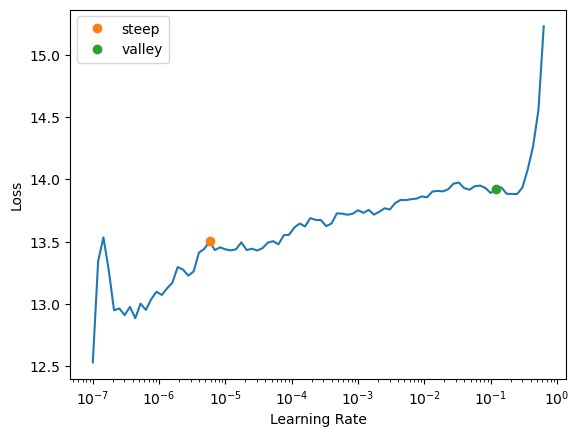

In [18]:
learn1.lr_find(suggest_funcs=(steep, valley))

In [19]:
learn1.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.301631,1.310965,00:03
1,1.022218,1.097294,00:03
2,0.898050,1.011744,00:03
3,0.755462,0.919856,00:03
4,0.726165,0.895173,00:03


### model with sigmoid_range()

In [20]:
class DotProductr(Module):
    def __init__(self, n_user, n_movie, n_factor, y_range):
        self.user_factors = Embedding(n_user, n_factor)
        self.movie_factors = Embedding(n_movie, n_factor)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users*movies).sum(dim=1), *self.y_range)

In [21]:
m2 = DotProductr(n_user, n_movie, 50, y_range=(0,5.5))

In [22]:
learn2 = Learner(dls, m2, MSELossFlat())

SuggestedLRs(steep=1.0964781722577754e-06, valley=0.009120108559727669)

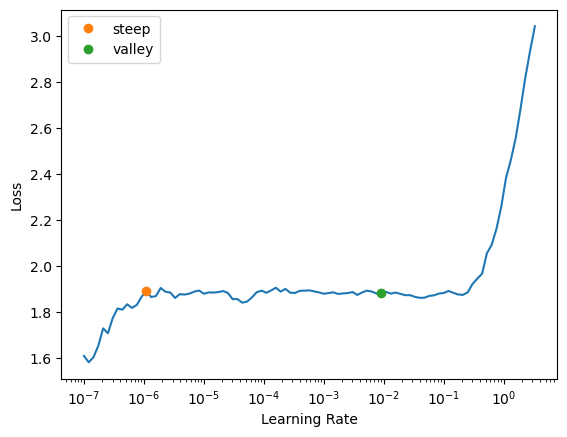

In [23]:
learn2.lr_find(suggest_funcs=(steep, valley))

In [24]:
learn2.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.937177,0.994447,00:03
1,0.643326,0.950007,00:03
2,0.460865,0.955227,00:03
3,0.354145,0.958508,00:03
4,0.335086,0.956805,00:03


### Add weight decay

In [25]:
learn2.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.374202,0.944885,00:03
1,0.410524,0.945799,00:04
2,0.379035,0.925004,00:03
3,0.338164,0.905625,00:03
4,0.309734,0.901353,00:03


### Add bias factors + weight decay

In [26]:
#user_bias(n_users,1), movie_bias(n_movie,1)
class DotProductwithbias(Module):
    def __init__(self, n_user, n_movie, n_factor, y_range=(0,5.5)):
        self.user_factors = Embedding(n_user, n_factor)
        self.movie_factors = Embedding(n_movie, n_factor)
        self.user_bias = Embedding(n_user, 1) 
        self.movie_bias = Embedding(n_movie, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users*movies).sum(dim=1, keepdim=True) #keepdim ensures output shape is (value,1) instead of (value,)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [27]:
m3 = DotProductwithbias(n_user, n_movie, 50)

In [28]:
learn3 = Learner(dls, m3, MSELossFlat())

SuggestedLRs(minimum=0.025118863582611083, valley=0.033113110810518265)

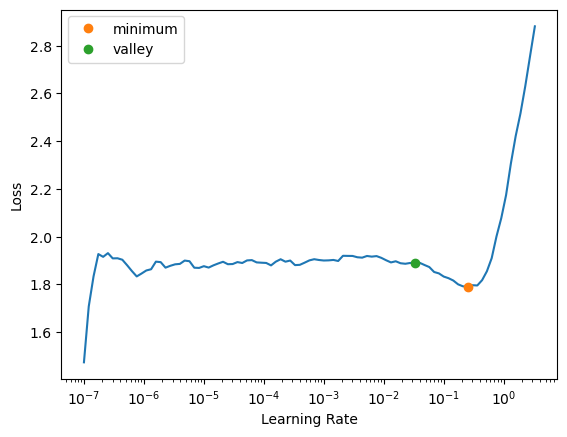

In [29]:
learn3.lr_find(suggest_funcs=(minimum, valley))

In [30]:
learn3.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.881795,0.948689,00:04
1,0.651870,0.897229,00:04
2,0.532466,0.877675,00:04
3,0.445856,0.860528,00:04
4,0.448806,0.856530,00:04


## Use nn.Parameter() to replace Embedding

(To understand deeper in `Embedding` structure🤓)

Manually create a learnable matrix -- define the size with Guassian distribution (mean=0, std=0.01).

Careful when lookup, manually : `params[input_id]`

100,000 ratings for 943 users (<1000 user_id) has no impact; But if >1 million user_id, use Embedding is better.

In [31]:
def create_param(size):
    return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

In [32]:
class DotProductwithparam(Module):
    def __init__(self, n_user, n_movie, n_factor, y_range=(0,5.5)):
        self.user_factors = create_param([n_user, n_factor])
        self.user_bias = create_param([n_user, 1])
        self.movie_factors = create_param([n_movie, n_factor])
        self.movie_bias = create_param([n_movie, 1])
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1, keepdim=True)
        res += self.user_bias[x[:,0]]+ self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [33]:
m4 = DotProductwithparam(n_user, n_movie, 50)

In [34]:
learn4 = Learner(dls, m4, MSELossFlat())

In [35]:
learn4.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.882108,0.954270,00:04
1,0.666175,0.904384,00:04
2,0.519925,0.884010,00:04
3,0.457408,0.865383,00:04
4,0.441064,0.862121,00:04


## Interpretation
### movie bias

In [36]:
low_5_idx = learn4.model.movie_bias.squeeze().argsort()[:5]
high_5_idx = learn4.model.movie_bias.squeeze().argsort(descending=True)[:5]

In [37]:
[dls.classes['title'][o] for o in low_5_idx] #5 movies with lowest movie_bias

['Children of the Corn: The Gathering (1996)',
 'Body Parts (1991)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Robocop 3 (1993)',
 'Free Willy 3: The Rescue (1997)']

In [38]:
[dls.classes['title'][o] for o in high_5_idx] #5 movies with highest movie_bias

['Titanic (1997)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'As Good As It Gets (1997)',
 'L.A. Confidential (1997)']

### Embedding visualization
Select top 50 movies embeddings

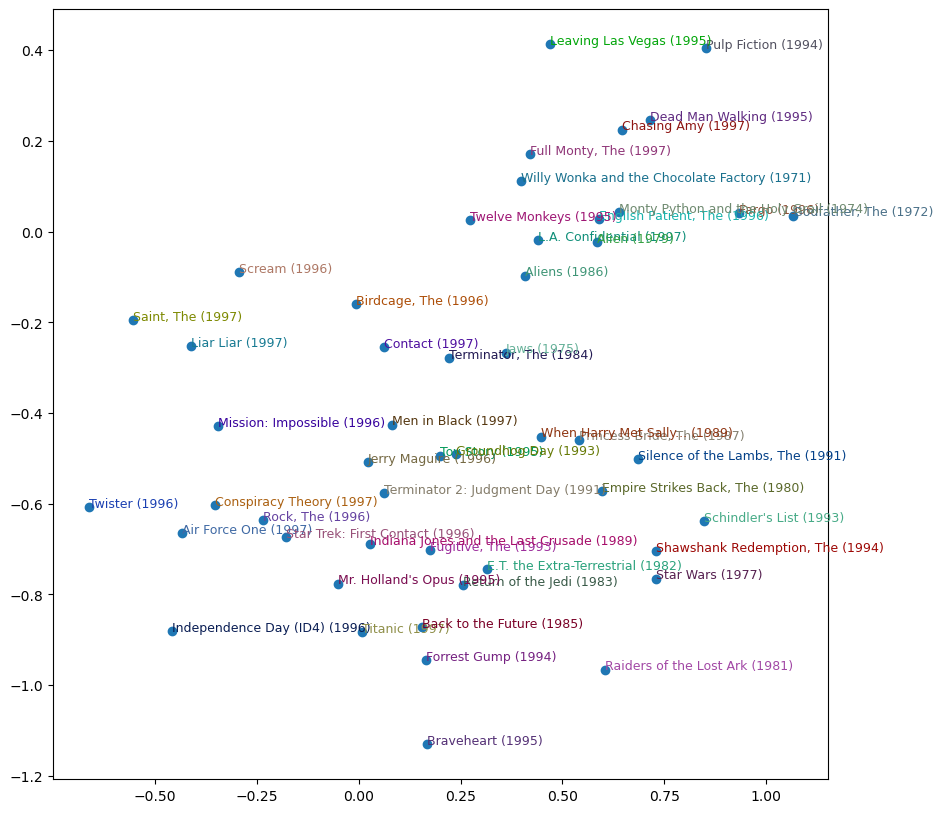

In [39]:
g = ratings.groupby('title')['rating'].count() #count nums of ratings every movie -> popular movies
top_movies = g.sort_values(ascending=False).index.values[:1000] #select most popular 1000 of total 1664 movies
top_idx = tensor([learn4.dls.classes['title'].o2i[i] for i in top_movies]) #given title, find its idx, to find the embeddings (by idx)
movie_weights = learn4.model.movie_factors[top_idx].cpu().detach()
movie_pca = movie_weights.pca(3) #shape=(w,3)learn4 embedding has 50 factors (dims) -> pca to 3 dims 
f1, f2, f3 = movie_pca.t() #(3,w)
#select top 50
idx = list(range(50))
X = f1[idx]
Y = f2[idx]
plt.figure(figsize=(10,10))
plt.scatter(X,Y)
for i, x, y in zip(top_movies[idx], X, Y):
    plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=9)
plt.show()

## fastai - collab_learner()

In [40]:
learn5 = collab_learner(dls, 50, y_range=(0, 5.5), loss_func=MSELossFlat())
set_seed(44, reproducible=True)
learn5.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [41]:
learn5.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.894730,0.946643,00:04
1,0.659328,0.902291,00:04
2,0.530802,0.874278,00:04
3,0.459777,0.861276,00:04
4,0.428101,0.857935,00:04


In [42]:
idx_5 = learn5.model.i_bias.weight.squeeze().argsort(descending=True)[:5]
[learn5.dls.classes['title'][o] for o in idx_5] #5 movies with highest movie_bias

['Titanic (1997)',
 "Schindler's List (1993)",
 'Star Wars (1977)',
 'Apt Pupil (1998)',
 'Close Shave, A (1995)']

## Deep learning model
Build a neural network for this dataset.
The NN structure is from paper's base model: Neural Collaborative Filtering [https://arxiv.org/abs/1708.05031]

### Base NN model
- hidden 1 layer : n_act=100

In [43]:
embs = get_emb_sz(dls) #automatically give embedding size
embs

[(944, 74), (1665, 102)]

In [44]:
class CollabNN(Module):
    def __init__(self, user_sz, movie_sz, y_range=(0, 5.5), n_act=100):
        self.user_factors=Embedding(*user_sz)
        self.movie_factors=Embedding(*movie_sz)
        self.y_range = y_range
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+movie_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1)
        )
    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.movie_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [45]:
m6 = CollabNN(*embs)

In [46]:
learn6 = Learner(dls, m6, MSELossFlat())

SuggestedLRs(minimum=0.00831763744354248, valley=0.0014454397605732083)

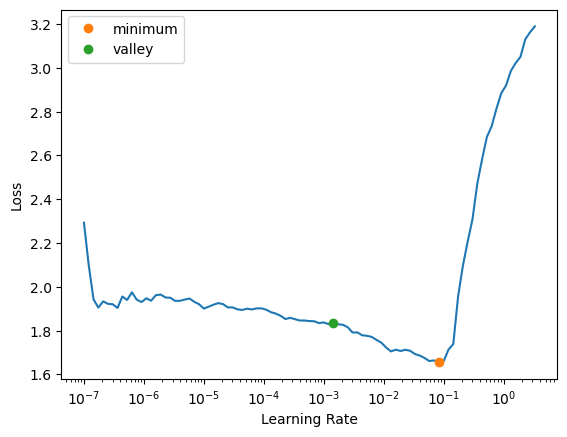

In [47]:
learn6.lr_find(suggest_funcs=(minimum, valley))

In [48]:
learn6.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.929227,0.984164,00:04
1,0.887141,0.925043,00:04
2,0.818727,0.921359,00:04
3,0.761186,0.883243,00:04
4,0.805905,0.874813,00:04


### fastai - collab_learner can also receive NN model
- hidden 2 layers: [100, 50]

SuggestedLRs(valley=0.00363078061491251)

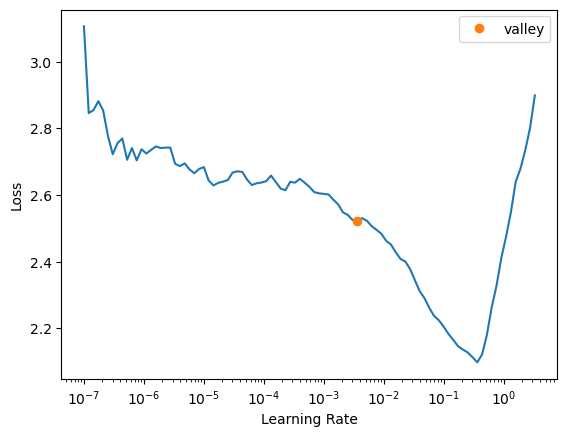

In [49]:
learn6_1 = collab_learner(dls, m6, use_nn=True, layers=[100,50], y_range=(0,5.5))
learn6_1.lr_find()

In [50]:
learn6_1.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.948409,1.003966,00:06
1,0.894804,0.925864,00:06
2,0.826107,0.897853,00:06
3,0.764514,0.880038,00:06
4,0.723839,0.882010,00:06


### CollabNN + bias + dropout + weight decay 

In [51]:
class CollabNNpro(Module):
    def __init__(self, user_sz, movie_sz, y_range=(0, 5.5), n_act=100, dropout_p=0.4):
        self.user_factors=Embedding(*user_sz)
        self.movie_factors=Embedding(*movie_sz)
        self.user_bias = Embedding(user_sz[0],1)
        self.movie_bias = Embedding(movie_sz[0],1)
        self.y_range = y_range
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+movie_sz[1], n_act),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(n_act, n_act//2),
            nn.ReLU(),
            nn.Dropout(dropout_p/2),
            nn.Linear(n_act//2, 1)
        )
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        users_bias = self.user_bias(x[:,0]).squeeze()
        movie_bias = self.movie_bias(x[:,1]).squeeze()
        out = self.layers(torch.cat([users, movies], dim=1)).squeeze()
        res = out + users_bias + movie_bias
        return sigmoid_range(res, *self.y_range)

In [52]:
m6_2 = CollabNNpro(*embs)

SuggestedLRs(valley=0.0030199517495930195)

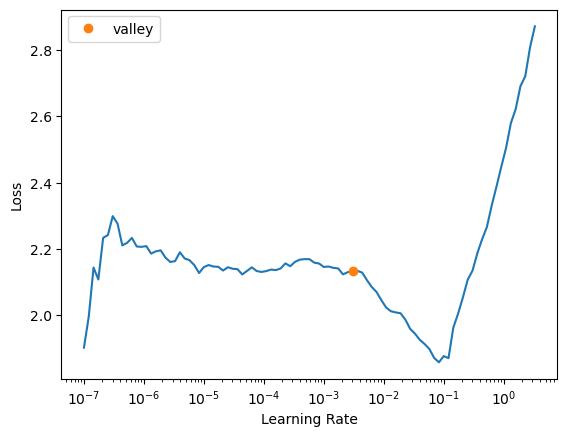

In [53]:
learn6_2 = Learner(dls, m6_2, MSELossFlat())
learn6_2.lr_find()

In [54]:
learn6_2.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.956582,1.004055,00:06
1,0.865183,0.915047,00:06
2,0.833166,0.894081,00:06
3,0.806568,0.883118,00:06
4,0.776061,0.876206,00:06


Adding bias、dropout、deep layers perform more loss? In fact, these are regularization methods, which will sacrifices model perfomance a bit...But will perform better in test/validset.


## Model evaluation summary

In [55]:
def model_performance_table(learners, names=None):
    results = []

    for i, learner in enumerate(learners):
        name = names[i] if names else f'Model_{i+1}'
        
        p, t = learner.get_preds(dl=learner.dls.valid)
        p = p.squeeze()

        rmse_val = rmse(t, p)
        mae_val = mae(t, p)

        results.append({
            'Model': name,
            'RMSE': round(rmse_val.item(), 4),
            'MAE': round(mae_val.item(), 4)
        })

    df = pd.DataFrame(results)
    return df

In [56]:
learners = [learn1, learn2, learn3, learn4, learn5, learn6, learn6_1, learn6_2]
names = ['DotProduct_Base', 'DotProduct_y_range', 'DotProduct_bias', 'nn_param', 'Collab_learner', 'Deep_1h', 'Deep_2h', 'Deep_2h_bias_dropout']

model_performance_table(learners, names)

,Model,RMSE,MAE
0,DotProduct_Base,0.9461,0.7360
1,DotProduct_y_range,0.9494,0.7503
2,DotProduct_bias,0.9255,0.7308
3,nn_param,0.9285,0.7329
4,Collab_learner,0.9262,0.7314
5,Deep_1h,0.9353,0.7328
6,Deep_2h,0.9392,0.7369
7,Deep_2h_bias_dropout,0.9361,0.7317


- I experimented with various collaborative filtering architectures on the MovieLens 100K dataset. The basic DotProduct model served as the baseline, yielding an RMSE 0.94. After introducing rating range constraints (y_range) and bias terms, the model’s performance improved significantly.

- I then implemented a CollabNN model using a multi-layer perceptron (MLP) architecture, which further enhanced generalization ability. This model currently achieves an RMSE of 0.926 and is my best-performing version so far.

- In deeper architectures (with additional hidden layers and dropout), I observed a slight degradation in performance on this small-to-medium-sized dataset. This led me to carefully consider the trade-off between model complexity and dataset scale when designing architectures.

## Recommendations
- embedding distance (cosine_similarity)
- use the best model (`learn5` - Collab_learner) to give recommendations following:

### Recommend the most similar movie by given a movie title:

In [57]:
def Rec_similar_movie(model, title):
    movie_factors = model.model.i_weight.weight #movie weights
    movie_idx = dls.classes['title'].o2i[title] #find the target movie's idx
    distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[movie_idx][None])
    target_idx = distances.argsort(descending=True)[1] #most similar one
    return dls.classes['title'][target_idx]

In [58]:
Rec_similar_movie(learn5, 'Titanic (1997)')

'Braveheart (1995)'

### Recommend a user's movie rating prediction by given user_id and movie title

In [59]:
def Predict_rating(learn6, user_id, title):
    movie_id = ratings.loc[ratings['title']==title, 'movie id'].values[0]
    device = learn6.model.i_weight.weight.device
    x = tensor([[user_id, movie_id]]).to(device)
    return learn6.model(x).item()

In [60]:
Predict_rating(learn5, user_id=12, title='Titanic (1997)')

4.29523229598999

### Recommand a user the top-N unseen movies

In [76]:
def Rec_top_n(user_id, n=5):

    user_map = learn5.dls.classes['user id']
    item_map = learn5.dls.classes['title']

    
    seen_titles = ratings[ratings['user id'] == user_id]['title'].values
    all_titles = ratings['title'].unique()
    unseen_titles = [t for t in all_titles if t not in seen_titles and t in item_map.o2i]

    user_idx = user_map.o2i[user_id]
    item_idxs = [item_map.o2i[t] for t in unseen_titles]

    device = learn5.model.i_weight.weight.device
    x = tensor([[user_idx, i] for i in item_idxs]).to(device)
    preds = learn5.model(x).squeeze()

    top_idxs = preds.argsort(descending=True)[:n]
    top_titles = [unseen_titles[i] for i in top_idxs]

    return top_titles

In [77]:
Rec_top_n(12)

['Braveheart (1995)',
 'Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 "It's a Wonderful Life (1946)",
 'Good Will Hunting (1997)']

## Apply the model in Gradio demo

In [63]:
#learn5 is training on mps (my device), need move to cpu (gradio only cpu-running)
learn5.model.cpu()
learn5.export('export.pkl')
ratings.to_csv('ratings.csv', index=False)

app.py

In [80]:
import gradio as gr
import pandas as pd
import torch
from fastai.collab import load_learner
from fastai.torch_core import tensor

# ✅ Load model & data
learn5 = load_learner('export.pkl')
ratings = pd.read_csv('ratings.csv')

# 👇 封闭环境，使用外部变量
def Rec_top_n(user_id, n=5):
    # user 和 item 的映射表
    user_map = learn.dls.classes['user id']
    item_map = learn.dls.classes['title']

    if user_id not in user_map.o2i:
        return f"❌ User ID {user_id} not found in training data."

    # 获取用户已看和未看电影（按 title）
    seen_titles = ratings[ratings['user id'] == user_id]['title'].values
    all_titles = ratings['title'].unique()
    unseen_titles = [t for t in all_titles if t not in seen_titles and t in item_map.o2i]

    if len(unseen_titles) == 0:
        return f"⚠️ No unseen movies for user {user_id}"

    user_idx = user_map.o2i[user_id]
    item_idxs = [item_map.o2i[t] for t in unseen_titles]

    device = learn.model.i_weight.weight.device
    x = tensor([[user_idx, i] for i in item_idxs]).to(device)
    preds = learn.model(x).squeeze()

    top_idxs = preds.argsort(descending=True)[:n]
    top_titles = [unseen_titles[i] for i in top_idxs]

    return "\n".join([f"{i+1}. {title}" for i, title in enumerate(top_titles)])

demo = gr.Interface(
    fn=Rec_top_n,
    inputs=gr.Number(label="User ID (Hint: 1~943)"),
    outputs=gr.Textbox(label="Top Movie Recommendations"),
    title="🎬 Movie Recommender (MovieLens 100K)",
    description="Enter a User ID to get top-N movie recommendations based on collaborative filtering."
)

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7865
* Running on public URL: https://f87657a0ffeb624026.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Upload files to build in Huggingface Space:
- files: `app.py`, `requirements.txt`, `export.pkl`, `ratings.csv`
- check the link: https://huggingface.co/spaces/apple9855/movie-recommend 